# HDS5210 Final

This final examination is similar in scale to the midterm from several weeks ago, but covers the scope of the entire semester.  The final also attempts to create a real-world scenario that you might encounter as a data scientist is the field.  Our goal with this final is to compile the data required to be able to understand any possible relationship between population, population density, and the spread of the COVID-19 coronavirus.  As in may real world cases, all of the data you need to do this analysis is not in one place, nicely formatted and compiled for you.  Through the final, you'll collect data from multiple sources and build your analytic dataset in a process that is documented, automated, and reproducable.

<img style='float:right' width='480px' src='https://www.lucidchart.com/publicSegments/view/095390af-7150-4dae-ac06-b98f10463cc7/image.png'>

The data you need for this final is all publicly available and real data.  The three data sources that you are reuquired to use are described in the list below and in the relationship diagram to the right.

* **Corona Virus Testing and Death Reports** - A MySQL database table that I loaded data into from the JSON file below.

 `https://coronadatascraper.com/timeseries.json`

 `corona_counts`
 
* **Location Metadata** -- A JSON file from the Corona Data Scrapper project that has a mapping of location identifiers to the location information.

 `https://coronadatascraper.com/locations.json`

* **Census Information** - Information available on Wikipedia about the population and geographic size of the counties in Missouri. 

 `https://en.wikipedia.org/wiki/List_of_counties_in_Missouri`

*Note that ALL of the data above is real data.  We'll be doing some analysis that is not necessarily standard for epidemiological studies, but should be interesting nonetheless.*

You will be asked to solve a number of different problems using this data.  As in previous assignments, there will be `assert()` statements to help you validate your work along the way.  We'll try to use old enough data so that the numbers shouldn't be changing, but it's possible that some of the data we use will be restated.


In [199]:
CORONA_COUNTS = 'corona_counts'
LOCATION_INFO = 'https://coronadatascraper.com/locations.json'
CENSUS_INFO = 'https://en.wikipedia.org/wiki/List_of_counties_in_Missouri'

# PART 1 - Get information about Missouri Counties

The **Corona Virus Testing and Death Reports** data is all in one place thanks to the work of the Corona Data Scraper project.  However, the data uses its own internal coding system to number the locations and the only reference data they have simply links those locations to [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) codes for US Counties.  Not very helpful.

Therefore, our first step will be to find somewhere that lists the FIPS code for every county in Missouri.  Thank you Wikipedia!  In fact, not only does our source have a mapping from FIPS code to county name, but it also has the population and physical area data that we also want.  So, let's start by retrieving that data from the HTML table on the ["List of counties in Missouri"](https://en.wikipedia.org/wiki/List_of_counties_in_Missouri) page.

Create a function named `get_mo_counties()` that pulls the information from this table and returns a dictionary keyed off the FIPS code and contains an entry for each of the attributes in the table.  Keep at least the elements we need: FIPS code, County, Population, Area as shown in the example below:

```
{ '001':
  { 'county': 'Adair County',
    'population': 25607,
    'area': 568
  },
  '002':
  { 'county': 'Andrew County',
    'population': 17291,
    'area': 435
  },
...
```

### TIPS

1. If you want to take a number and format it with leading 0s, this works: `"{:03d}".format(1)`

2. The Area column in this table uses a "non-breaking space" character between the number part and the "sq mi" part.  This is different than just the space bar.  If you want to tell Python to look for a non-breaking space, you can type `\xa0`

In [200]:
from bs4 import BeautifulSoup as bs


In [201]:
import pandas as pd
import requests
import csv
import re

def get_mo_counties(url=CENSUS_INFO):
    
    output = {}
    html_data = requests.get(CENSUS_INFO).text
    county_names = bs(html_data, "lxml").find("table", attrs={"class": "wikitable"}).find_all("tr")
    column_names = bs(html_data, "lxml").find("table", attrs={"class": "wikitable"}).find_all("th") 
    
    for county in county_names[1:len(county_names)]:
        county_info = dict()
        county_info["county"] = county.find("th").get_text().replace('\n', ' ').strip()
        a = county.find_all("td")
        county_info["area"] = float(re.search(r'^[0-9.]+', a[6].get_text().replace('\n', ' ').replace(',', '').strip(), re.IGNORECASE).group(0))        
        county_info["population"] = float(a[5].get_text().replace('\n', ' ').replace(',', '').strip())
        output[str(a[0].get_text().replace('\n', ' ').strip())] = county_info
    
    
    return output
                                            
display(get_mo_counties())

{'001': {'county': 'Adair County', 'area': 568.0, 'population': 25607.0},
 '003': {'county': 'Andrew County', 'area': 435.0, 'population': 17291.0},
 '005': {'county': 'Atchison County', 'area': 545.0, 'population': 5685.0},
 '007': {'county': 'Audrain County', 'area': 693.0, 'population': 25529.0},
 '009': {'county': 'Barry County', 'area': 779.0, 'population': 35597.0},
 '011': {'county': 'Barton County', 'area': 594.0, 'population': 12402.0},
 '013': {'county': 'Bates County', 'area': 848.0, 'population': 17049.0},
 '015': {'county': 'Benton County', 'area': 706.0, 'population': 19056.0},
 '017': {'county': 'Bollinger County', 'area': 621.0, 'population': 12363.0},
 '019': {'county': 'Boone County', 'area': 685.0, 'population': 162642.0},
 '021': {'county': 'Buchanan County', 'area': 410.0, 'population': 89201.0},
 '023': {'county': 'Butler County', 'area': 698.0, 'population': 42794.0},
 '025': {'county': 'Caldwell County', 'area': 429.0, 'population': 9424.0},
 '027': {'county': '

In [202]:
mo_counties = get_mo_counties()
assert(len(mo_counties) == 115)
assert(mo_counties.get('001').get('county') == 'Adair County')
assert(mo_counties.get('007').get('population') == 25529)
assert(mo_counties.get('011').get('area') == 594)

# PART 2 - Create a List of Missouri Counties from the Corona Data Scraper Locations File

Browse the **Location Metadata** JSON file on the website and you'll see that it is a list that contains a dictionary object for each of the locations for which this website has data.  Create a Python function called `get_mo_locations()` to read that JSON file from the URL provided above and transform that JSON into a simple dictionary that has only those locations that are in Missouri.  We're going to use this dictionary to filter the actual testing and death data file during the next step.  For the structure of that dictionary, it will be most useful if you has the position of the original list entry as the dictionary key and the county's FIPS code as the dictionary value.  The reason for this is that the location identifier in the testing and death data file is the index position for the appropriate location metadata in this file.

You'll notice that the FIPS code from this file includes a 2-digit prefix that has the state code of `29` on it.  You'll need to remove that and only keep the last three characters of the FIPS code so that it matches the three digit FIPS code from the Wikipedia page above.

The output returned from your `get_mo_locations()` function should look like the sample below and ONLY contain **the counties from Missouri**.

```
{1901: '001',
 1902: '003',
 1903: '005',
 1904: '007',
 1905: '009',
 1906: '011',
...
```


In [203]:
import pandas as pd
import requests
import json

def get_mo_locations(url=LOCATION_INFO):
    
    output = {}

    return output
    
info = json.loads(requests.get(LOCATION_INFO).text)
type(info)
len(info)


4530

In [204]:
import pandas as pd
import requests
import json

def get_mo_locations(url=LOCATION_INFO):
    info = json.loads(requests.get(LOCATION_INFO).text)
    mo_locations = list()
    output2 = {}
    i = 0

    for location in info:
        if(location.get("state") == "Missouri") & ( location.get("county") != None ):
           # print(location)
            a = location.get("featureId")[-3:]
            output2[i - 2] = a
        i = i + 1
    return output2
    
    

In [205]:
mo_locations = get_mo_locations()
assert(len(mo_locations) == 115)
assert(mo_locations.get(1901) == '001')

In [206]:
display(mo_locations)

{1901: '001',
 1902: '003',
 1903: '005',
 1904: '007',
 1905: '009',
 1906: '011',
 1907: '013',
 1908: '015',
 1909: '017',
 1910: '019',
 1911: '021',
 1912: '023',
 1913: '025',
 1914: '027',
 1915: '029',
 1916: '031',
 1917: '033',
 1918: '035',
 1919: '037',
 1920: '039',
 1921: '041',
 1922: '043',
 1923: '045',
 1924: '047',
 1925: '049',
 1926: '051',
 1927: '053',
 1928: '055',
 1929: '057',
 1930: '059',
 1931: '061',
 1932: '063',
 1933: '065',
 1934: '067',
 1935: '069',
 1936: '071',
 1937: '073',
 1938: '075',
 1939: '077',
 1940: '079',
 1941: '081',
 1942: '083',
 1943: '085',
 1944: '087',
 1945: '089',
 1946: '091',
 1947: '093',
 1948: '095',
 1949: '097',
 1950: '099',
 1951: '101',
 1952: '103',
 1953: '105',
 1954: '107',
 1955: '109',
 1956: '111',
 1957: '113',
 1958: '115',
 1959: '117',
 1960: '119',
 1961: '121',
 1962: '123',
 1963: '125',
 1964: '127',
 1965: '129',
 1966: '131',
 1967: '133',
 1968: '135',
 1969: '137',
 1970: '139',
 1971: '141',
 1972:

# PART 3 - Corona Virus Cases for Missouri Counties

Next, we're going to use the data available in the **Corona Virus Testing and Death Reports** data in the MySQL **corona_counts** table.  This data will need to be filtered down to only contain the information for Missouri Counties.

Create a function called `get_corona_counts()` that retrieves retrieves information from the same MySQL database we used before.  I've provided the connection information for your convenience.  Your function will need to make the database connect and retrieve the data from the **corona_counts** table.  It should use the output from the `get_mo_locations()` function to filter the information in the table and return a dataframe with only the data for Missouri counties.

In [207]:
# Then, this code will automatically setup your 
import os
from sqlalchemy import create_engine
import pandas as pd

host = 'slucor2020.cgdcoitnku0k.us-east-1.rds.amazonaws.com'
port = '3306'
user = 'slucor2020'
password = 'SLUcor2020'
database = 'hds5210'

conn = create_engine('mysql+pymysql://' + 
                     user + ':' + 
                     password + '@' + 
                     host + ':' + 
                     str(port) + '/' + 
                     database)

display(pd.read_sql_query("SELECT * FROM corona_counts", conn))

,idx,dt,location,cases,deaths,hospitalized,discharged
0,0,2020-01-22,0,4.0,NaN,NaN,NaN
1,1,2020-01-22,1,11.0,NaN,NaN,NaN
2,2,2020-01-22,2,6.0,NaN,NaN,NaN
3,3,2020-01-22,3,3.0,NaN,NaN,NaN
4,4,2020-01-22,4,24.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
400358,400358,2020-04-30,4525,46.0,NaN,NaN,NaN
400359,400359,2020-04-30,4526,15.0,NaN,NaN,NaN
400360,400360,2020-04-30,4527,1.0,NaN,NaN,NaN
400361,400361,2020-04-30,4528,9057.0,1035.0,NaN,NaN


In [208]:
def get_corona_counts(locations, conn, table=CORONA_COUNTS):

    output3 = pd.DataFrame()
    df = pd.read_sql_query("SELECT * FROM " + table.lower(), conn)
    for keys in locations.keys():
        a = df.loc[df['location'] == keys]
        output3 = output3.append(a)
    return output3

output3 = pd.DataFrame()
locations = get_mo_locations()
df = pd.read_sql_query("SELECT * FROM corona_counts", conn)
for keys in locations.keys():
    a = df.loc[df['location'] == keys]
    output3 = output3.append(a)

In [209]:
mo_corona = get_corona_counts(get_mo_locations(), conn)
print(mo_corona)

           idx          dt  location   cases  deaths  hospitalized  discharged
1901      1901  2020-01-22      1901     0.0     0.0           NaN         NaN
5610      5610  2020-01-23      1901     0.0     0.0           NaN         NaN
9319      9319  2020-01-24      1901     0.0     0.0           NaN         NaN
13028    13028  2020-01-25      1901     0.0     0.0           NaN         NaN
16737    16737  2020-01-26      1901     0.0     0.0           NaN         NaN
...        ...         ...       ...     ...     ...           ...         ...
380057  380057  2020-04-26      2015  1007.0    50.0           NaN         NaN
384496  384496  2020-04-27      2015  1027.0    54.0           NaN         NaN
388951  388951  2020-04-28      2015  1054.0    55.0           NaN         NaN
393390  393390  2020-04-29      2015  1067.0    56.0           NaN         NaN
397884  397884  2020-04-30      2015  1077.0    57.0           NaN         NaN

[11500 rows x 7 columns]


In [211]:
mo_corona = get_corona_counts(get_mo_locations(), conn)
assert(mo_corona['dt'].value_counts().mean() == 115)
assert(mo_corona['location'].value_counts().mean() == 100)
assert('dt' in mo_corona.columns)
assert('location' in mo_corona.columns)
assert('cases' in mo_corona.columns)

## PART 4 - Calculate Doubling Time between 3/1 and 3/31

The next step in our process is to calculate the doubling time for each county.  [Doubling time](https://en.wikipedia.org/wiki/Doubling_time) is calculated by computing:

```
doubling_time = ln(2) / growth_rate
```

where growth rate is calculated by:

```
growth_rate = ln(N(t) / N(0)) / t

N(t) = number at time t
N(0) = number at start time
t    = number of time units (we'll use days)
```

In this part, you should create a function called `calc_doubling_rate()` that takes the dataframe output from your `get_corona_counts()` function and returns four Series (columns): location, cases on start date, cases on end date, and the doubling rate calculated based start and end date that you provide.  You can assume start and end date are strings in the format YYYY-MM-DD.

Special rules:
* If the count at the start or the end is 0 then the doubling_time should be NaN
* If the count on the end date is less than the count on the start date, then the doubling_time should be NaN

Once we have a data frame with only one row per county, we can merge that in with the census information from step 1 and start looking at some relationships.



### TIPS

1. You'll need to calculate some natural logs as shown above.  The way to do that with Pandas requires **`import numpy as np`** and then something like **`np.log2(df['cases'])`**

2. The right way to overwrite some of the rows under a particular column is by using he df.loc(row_indexer, col_indexer) syntax.  For instance, if you have a filter called `my_filter`, then updating the doubling_time column would look like this:  `output.loc[my_filter, 'my_column'] = np.nan`

In [212]:
import numpy as np
from dateutil.parser import parse
import datetime

def endpoint(df, start='2020-04-01', end='2020-04-20'):
    locations = list()
    output4 = pd.DataFrame(columns=(['location', 'start', 'end']))
    locations = df['location'].unique()
    for location in locations:
        last_row = df.loc[ ( (df['location'] == int(location)) & (df['dt'] == end) )]
        first_row = df.loc[ ( (df['location'] == int(location)) & (df['dt'] == start) )]
        
        output4 = output4.append({ 'location':str(location), 'end': int(last_row['cases']), 'start': int(first_row['cases']) }, ignore_index=True)
    return output4.set_index('location', drop=False)

def calc_doubling_rate(df, start='2020-04-01', end='2020-04-20'):  
    if ( parse(start) >= parse(end) ):
        raise Exception("state date before end date")
        
    output4 = endpoint(df, start, end)
    output4['doubling_time'] = np.nan
    for location in list(output4.index):
        starting = output4.at[location, 'start']
        ending = output4.at[location, 'end']
        
        try:
            if( (starting == 0) or (ending == 0) or (starting >= ending) ):
                output4.at[location, 'doubling_time'] = np.nan
            else: 
                x = ending/starting
                y = ( ( parse(end) - parse(start) ).days )
                output4.at[location, 'doubling_time'] = np.log(2) / ( np.log(x)  / y )
        except:
            output4.at[location, 'doubling_time'] = np.nan
    return output4
        


In [213]:
mo_doubling = calc_doubling_rate(mo_corona)
assert(len(mo_doubling) == 115)
assert(round(mo_doubling['start'].mean(),2) == 13.73)
assert(round(mo_doubling['end'].mean(),2) == 50.48)
print(round(mo_doubling['doubling_time'].min(),2))

4.14


In [214]:
display(mo_doubling)

,location,start,end,doubling_time
location,,,,
1901,1901,3,12,9.500000
1902,1902,0,1,NaN
1903,1903,1,2,19.000000
1904,1904,0,1,NaN
1905,1905,1,4,9.500000
...,...,...,...,...
2011,2011,0,0,NaN
2012,2012,2,10,8.182855
2013,2013,0,1,NaN


# Part 5 - Merge the Census and Corona Data

In this step, we'll finally get our corona virus data merged with the location data and then the census data so that we can compare doubling time and population or population density.  To do this, write a function called `merge_corona_census()` that does the merge and returns a single data frame with all of the columns as output.

You will also need to calculate the population density for each as the ration of the population to the area:
```
  density = population / area
```

In [215]:
def merge_corona_census(corona, locations, census):
    census_df = pd.DataFrame.from_dict(census, orient= 'index')
    locations_df = pd.DataFrame.from_dict(locations, orient= 'index', columns = ['FIPS_code'])
    locations_df.insert(0, "location",locations_df.index)
    census_df['FIPS_code'] = census_df.index
    corona['location'] = corona['location'].astype(int)
    corona = corona.reset_index(drop=True).merge(locations_df, on="location")
    output5 = corona.merge(census_df, how="left", on='FIPS_code')
    output5['density'] = output5['population'] / output5['area']
    return output5


In [216]:
results = merge_corona_census(mo_doubling, mo_locations, mo_counties)
assert(len(results) == 115)
assert(round(results['density'].mean(),2) == 131.71)

In [217]:
display(results)

,location,start,end,doubling_time,FIPS_code,county,area,population,density
0,1901,3,12,9.500000,001,Adair County,568.0,25607.0,45.082746
1,1902,0,1,NaN,003,Andrew County,435.0,17291.0,39.749425
2,1903,1,2,19.000000,005,Atchison County,545.0,5685.0,10.431193
3,1904,0,1,NaN,007,Audrain County,693.0,25529.0,36.838384
4,1905,1,4,9.500000,009,Barry County,779.0,35597.0,45.695764
...,...,...,...,...,...,...,...,...,...
110,2011,0,0,NaN,223,Wayne County,761.0,13521.0,17.767411
111,2012,2,10,8.182855,225,Webster County,593.0,36202.0,61.048904
112,2013,0,1,NaN,227,Worth County,266.0,2171.0,8.161654
113,2014,4,9,16.240357,229,Wright County,682.0,18815.0,27.587977


# Part 6 Observations

Below, I've provided some code to plot data from your results above.  This assumes that your results include the following columns:
* population
* density
* doubling_time


Take a few minutes and share your observations about the pattern or lack of pattern in the relationship between density, population, and doubling_time.  Put your comments in the text cell below.

---

### Your Response
There is a positive correlation between population and density shown in the first scatter plot with an upward trend, as the population increases the density is seen to increase as well. There is barely any correlation between density and doubling_time as well as no correlation between population and doubling_time in the second and third plots where the density or population stays pretty stagnant while the doubling is seen to vary. 


---

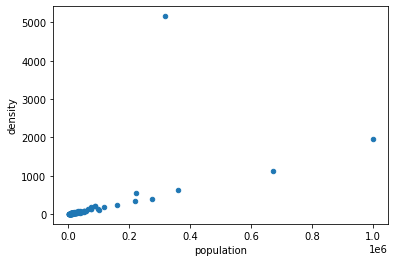

In [223]:
results.plot.scatter(x='population', y='density')

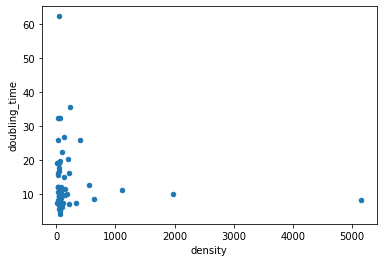

In [224]:
results.plot.scatter(x='density', y='doubling_time')

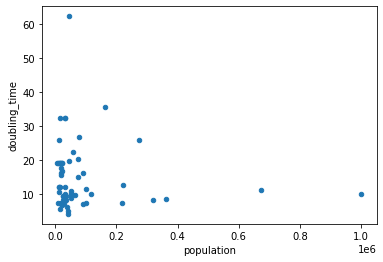

In [225]:
results.plot.scatter(x='population', y='doubling_time')

In [226]:
import seaborn as sns

[None]

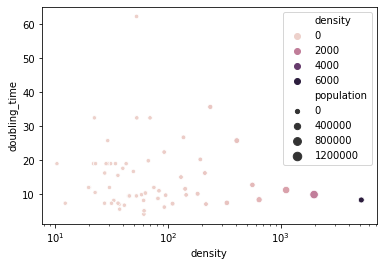

In [227]:
ax = sns.scatterplot(x="density", y="doubling_time",
                     hue="density", size="population",
                     data=results)

ax.set(xscale='log')